##掛載雲端硬碟


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

##更改檔案所在路徑

In [2]:
# # Change to your own folder !!!
# %cd /content/drive/MyDrive/Colab\ Notebooks/EAI_Lab4_2023

## Import library

In [3]:
from __future__ import print_function
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from models import vgg

## 設定超參數(填空)

In [4]:
SPARSITY_REGULARIZATION = True
#### 設定λ(balance factor) ####
################################################
#          請填空          #
################################################
LAMBDA = 1e-5 # try with 0, 1e-5, 1e-4

SEED = 1
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000
EPOCHS = 40
LEARNING_RATE = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
LOG_INTERVAL = 100
CUDA = True

RESUME = False
START_EPOCH = 0

WEIGHT_PATH = './model_best.pth'


In [5]:
if(torch.cuda.is_available()):
    CUDA = True
    kwargs = {'num_workers': 1, 'pin_memory': True}
    torch.cuda.manual_seed(SEED)
else:
    CUDA = False
    kwargs = {}


##下載資料集


這裡將訓練集做Augmentation(Pad, RandCrop, Random)，測試集不用做Augmentation

In [6]:
#### 資料集 ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

Files already downloaded and verified


## 定義模型與載入訓練好的權重

In [7]:
model = vgg()
if CUDA:
    model.cuda()

##設定Optimizer，這裡使用Stocastic Gradient Descent

In [8]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

##使用論文中稀疏化的方式更新參數(填空)

In [9]:
def updateBN():
  for m in model.modules():
      if isinstance(m, nn.BatchNorm2d):
          #### 完成Sparsity Regularization ####
          ################################################
          #          請填空          #
          ################################################
          m.weight.grad.data.add_(LAMBDA*torch.sign(m.weight.data)) # L1 regularization
          m.bias.grad.data.add_(LAMBDA*torch.sign(m.bias.data)) # L1 regularization





## 載入預先定義好的模型與參數

In [10]:
if(RESUME):
  checkpoint = torch.load(WEIGHT_PATH)
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  START_EPOCH = checkpoint['epoch'] 
  best_prec1 = checkpoint['best_prec1']
  print(f'RESUME MODEL @EPOCH={START_EPOCH}, BEST_PREC1={best_prec1}')

## 定義訓練跟測試函數

In [11]:
#### 訓練函數 #####

train_acc = []
test_acc = []

# 注意: 需自行撰寫儲存每個epoch之train acc的code，以便後續繪製train acc結果圖!
def train(epoch):
    model.train()
    accuracy_per_batch = []
    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()

        if SPARSITY_REGULARIZATION:
            updateBN()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
            
        # Store training accuracy of current batch
        pred = output.data.max(1, keepdim=True)[1]
        correct = pred.eq(target.data.view_as(pred)).cpu().sum()
        accuracy = correct / float(len(data))
        accuracy_per_batch.append(accuracy)
    
    # Store average training accuracy of current epoch
    train_acc.append(sum(accuracy_per_batch)/len(accuracy_per_batch))


#### 測試函數 ####
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if CUDA:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').data.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    
    # Store average test accuracy of current epoch
    test_acc.append(correct / float(len(test_loader.dataset)))

    return correct / float(len(test_loader.dataset))

best_prec1 = 0.
for epoch in range(START_EPOCH, EPOCHS):
    # Learning Rate在0.5EPOCHS與0.75EPOCHS調整為原本1/10
    if epoch in [EPOCHS*0.5, EPOCHS*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
    train(epoch)
    prec1 = test()

    # 儲存模型權重，方便做後續剪枝,後續訓練
    if(prec1 > best_prec1):
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizer.state_dict(),
        }, WEIGHT_PATH)

    best_prec1 = max(prec1, best_prec1)


Train Epoch: 0 [0/50000 (0.0%)]	Loss: 2.310723
Train Epoch: 0 [10000/50000 (20.0%)]	Loss: 1.791177
Train Epoch: 0 [20000/50000 (40.0%)]	Loss: 1.682863
Train Epoch: 0 [30000/50000 (60.0%)]	Loss: 1.454455
Train Epoch: 0 [40000/50000 (80.0%)]	Loss: 1.204586

Test set: Average loss: 1.3344, Accuracy: 5207/10000 (52.1%)

Train Epoch: 1 [0/50000 (0.0%)]	Loss: 1.160047
Train Epoch: 1 [10000/50000 (20.0%)]	Loss: 1.033234
Train Epoch: 1 [20000/50000 (40.0%)]	Loss: 1.132590
Train Epoch: 1 [30000/50000 (60.0%)]	Loss: 0.998852
Train Epoch: 1 [40000/50000 (80.0%)]	Loss: 0.804497

Test set: Average loss: 1.0040, Accuracy: 6515/10000 (65.2%)

Train Epoch: 2 [0/50000 (0.0%)]	Loss: 0.854869
Train Epoch: 2 [10000/50000 (20.0%)]	Loss: 0.953008
Train Epoch: 2 [20000/50000 (40.0%)]	Loss: 0.906286
Train Epoch: 2 [30000/50000 (60.0%)]	Loss: 0.754379
Train Epoch: 2 [40000/50000 (80.0%)]	Loss: 0.820232

Test set: Average loss: 0.8732, Accuracy: 7081/10000 (70.8%)

Train Epoch: 3 [0/50000 (0.0%)]	Loss: 0.871474

##繪製Sparsity-Training結果圖

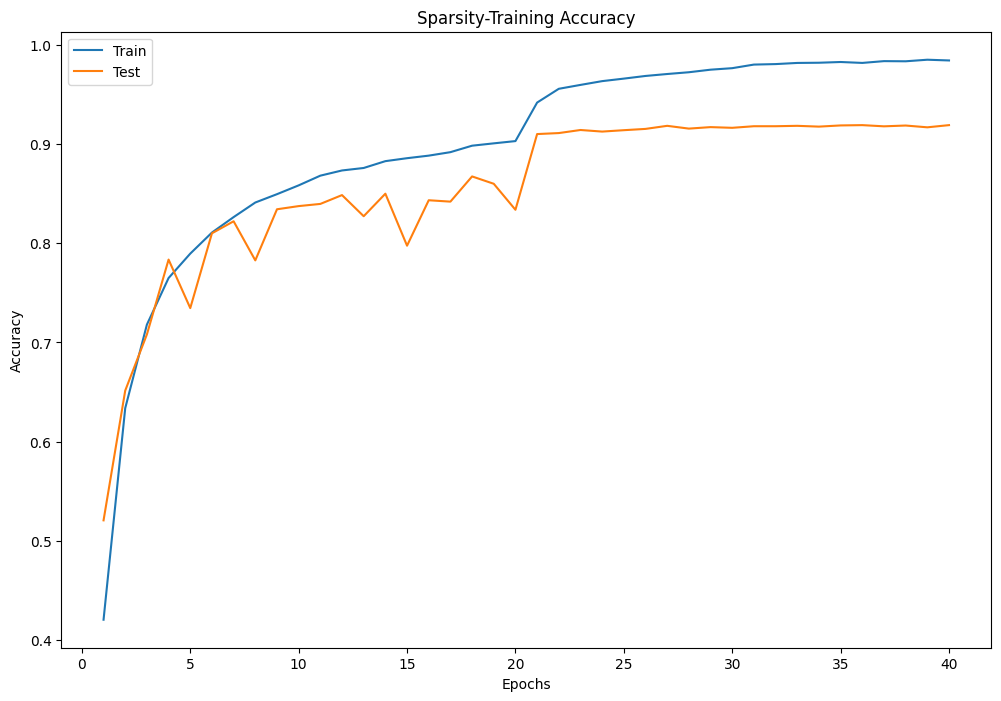

In [12]:
#繪製 Sparsity-Training 結果圖
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, EPOCHS+1), train_acc, label='Train')
plt.plot(np.arange(1, EPOCHS+1), test_acc, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Sparsity-Training Accuracy')
plt.legend()
plt.savefig(f'train_accuracy_{LAMBDA}.png')
plt.show()

## 繪製scaling factor 分布圖

(64,)
(64,)
(128,)
(128,)
(256,)
(256,)
(256,)
(256,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)
(512,)


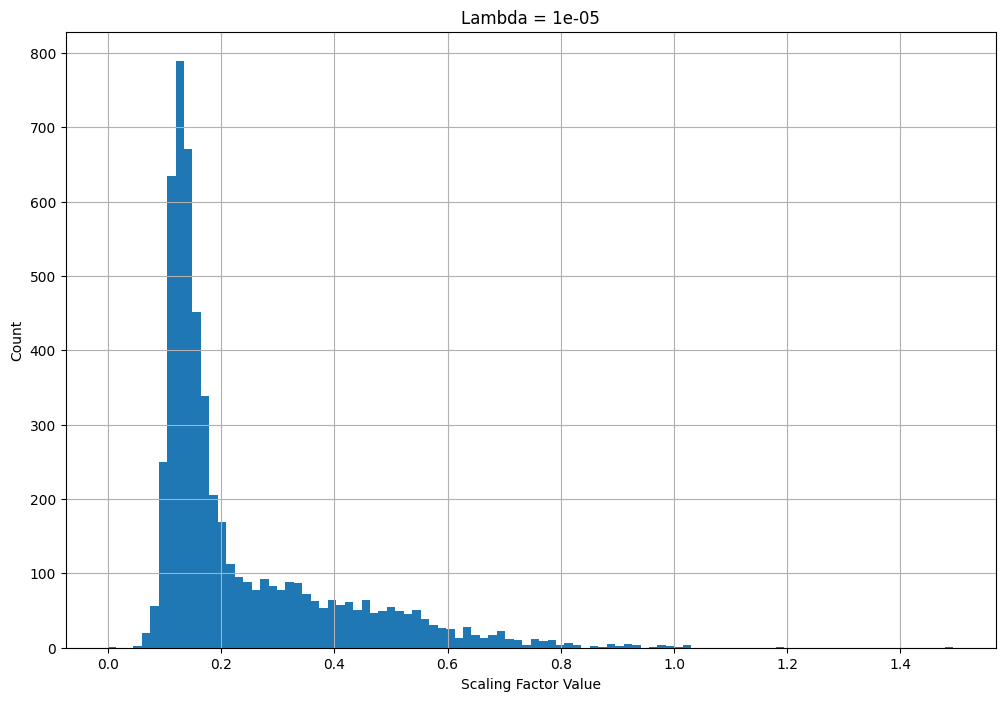

In [13]:
#繪製 scaling factor 分布圖

scaling_factor_list = []

for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        scaling_factor = m.weight.data.cpu().numpy()
        print(scaling_factor.shape) # in VGG19, there are 16 BN layers
        # print(scaling_factor) # each scaling factor is a 1D array
        scaling_factor_list.extend(scaling_factor)


plt.figure(figsize=(12, 8))
plt.hist(scaling_factor_list, bins=100)
plt.title(f'Lambda = {LAMBDA}')
plt.xlabel('Scaling Factor Value')
plt.ylabel('Count')
plt.grid()
plt.savefig(f'scaling_factor_{LAMBDA}.png')
plt.show()